In [1]:
import sys
sys.path.append('..')
from src.kitti import *
import numpy as np
import cv2
%matplotlib inline

Read frame transformations from KITTI sequence 00 into a list of frames (frame).

In [2]:
IMAGE_SIZE = 400

def load(file):
    keyframeids, frameids, poses = load_keyframes(file)
    return keyframeids, frameids, poses.reshape(poses.shape[0], 4, 4)

def load_csv(file):
    poses = np.genfromtxt(file, delimiter= " ")
    poses = np.hstack([poses, np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) ])
    return poses.reshape(poses.shape[0], 4, 4)

def transform(poses):
    points = np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) 
    for i in range(1, len(poses)):
        points[:i] = np.dot(points[:i], poses[i].T)
    return points
        
def transform2(poses):
    points = poses[:,:,3]
    return points
    
def plot_trajectory(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1])

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = IMAGE_SIZE / maxxy + pmin[1] / maxxy + 100

    return np.dot(points, t.T)
    

def plot_trajectory2(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1]) * 1.01

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = IMAGE_SIZE / maxxy + pmin[1] / maxxy + 100
    return np.dot(points, t.T)
    
def plot_trajectory3(points):
    coords = []
    minx = min([p[0] for p in points])
    maxx = max([p[0] for p in points])
    miny = min([p[2] for p in points])
    maxy = max([p[2] for p in points])
    maxxy = max(maxx - minx, maxy - miny)* 1.01

    for p in points:
        #print(p)
        x = IMAGE_SIZE * (p[0] - minx) / (maxxy)
        z = IMAGE_SIZE - IMAGE_SIZE * (p[2] - miny) / (maxxy)
        coords.append([x, z])
    return coords

def new_image():
    img = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), np.uint8)
    img[:] = 255 #or img.fill(255)
    return img

def draw(coords, img, color = (0,0,0)):
    # Draw a black line with thickness of 2 px
    for i in range(1,len(coords)):
        cv2.line(img, (int(coords[i - 1][0]), int(coords[i - 1][1])), (int(coords[i][0]), int(coords[i][1])), color, 2)
    return img

Compute the frame positions by mutiplying every point by a sequence of their transformations
vectorized to improve speed

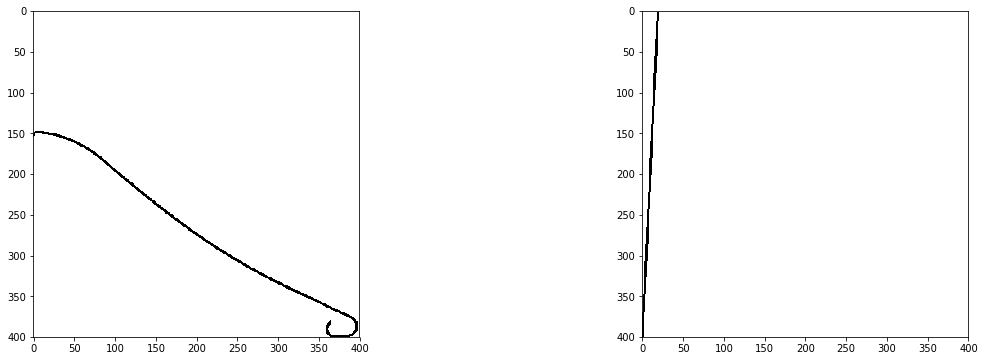

In [11]:
sequence = 1

keyframeids, frameids, poses = load('cv_keyframes.npy')
points = transform(poses)
coords = plot_trajectory3(points)
p = draw(coords, new_image())

gt = load_csv('/data/urbinn/datasets/kitti/poses/%02d.txt'%(sequence))
points = transform2(gt)
coords = plot_trajectory3(points)
show2(draw(coords, new_image()), p)

Show the affine world coodinates for the first 3 poses

In [4]:
points[:3]

array([[  1.11022300e-16,   2.22044600e-16,  -2.22044600e-16,
          1.00000000e+00],
       [  5.15465600e-02,  -2.42488300e-02,   1.00072500e+00,
          1.00000000e+00],
       [  1.46463200e-01,  -5.05162200e-02,   1.99565900e+00,
          1.00000000e+00]])

show the converted x,y coordinates to plot the trajectory

In [5]:
coords[:3]

[[0.0, 153.79385922266854],
 [0.011168696874392448, 153.57703012331396],
 [0.031734476249307773, 153.36145577158177]]